In [1]:
import pandas as pd
import os
from utils import *
from plots import *
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = '../data/'
PLOTS_DIR = './plots'

PVALUE = 0.05

### 1. Prepare all dfs

In [3]:
full_dfs = {
    '_'.join(os.path.splitext(file)[0].split('_')[3:]): pd.read_csv(DATA_DIR + file, decimal=',') 
    for file in os.listdir(DATA_DIR)
    }

In [4]:
text_feature_cols = list(list(full_dfs.values())[0].columns[24:])

In [5]:
len(text_feature_cols)

86

In [6]:
female_male_dfs = []

for model_name, df in full_dfs.items():
    female_df, male_df = prepare_dfs(df, text_feature_cols, model_name)
    record = {
        'model_name': model_name,
        'female_df': female_df,
        'male_df': male_df
    }
    female_male_dfs.append(record)

Missing columns: {'pronoun_LIWC'} in qwen_4B
Missing columns: {'pronoun_LIWC'} in qwen_14B


### 2. Calculate mean differences

In [7]:
all_mean_differences = dict()

for record in female_male_dfs:
    mean_differences = get_sorted_mean_differences(record['male_df'], record['female_df'], text_feature_cols, model_name)
    all_mean_differences[record['model_name']] = mean_differences

Missing columns: {'pronoun_LIWC'} in qwen_14B
Missing columns: {'pronoun_LIWC'} in qwen_14B


### 3. Plot per every model mean difference

In [ ]:
for model_name, mean_differences in all_mean_differences.items():
    plot_mean_differences(mean_differences, model_name, path_to_save=PLOTS_DIR+'/mean_differences_model', show=False)

### 4. Values that were most often in the top 10 in mean differences

In [9]:
counter_mean_diff = []

for model_name, mean_differences in all_mean_differences.items():
    top_10 = [feature for feature, _ in zip(mean_differences.keys(), range(5))]
    counter_mean_diff.extend(top_10)

most_common_mean_diff = Counter(counter_mean_diff).most_common(5)
most_common_mean_diff

[('Clout', 8), ('WC', 8), ('i', 7), ('unique_words_cnt', 6), ('Tone', 6)]

In [10]:
for feature, frequency in most_common_mean_diff[:5]:
    feature_means = dict()
    
    for model_name, mean_differences in all_mean_differences.items():
        try:
            feature_means[model_name] = mean_differences[feature]
        except KeyError: # ('pronoun_LIWC' attacks again)
            continue
    
    plot_mean_differences(feature_means, feature, PLOTS_DIR+'/mean_differences_feature', show=False)

### 5. Total mean difference in every model

In [11]:
total_mean_diff = dict()

for model_name, mean_differences in all_mean_differences.items():
    
    total =  np.mean(np.abs(np.array(list(mean_differences.values()))))
    total_mean_diff[model_name] = total

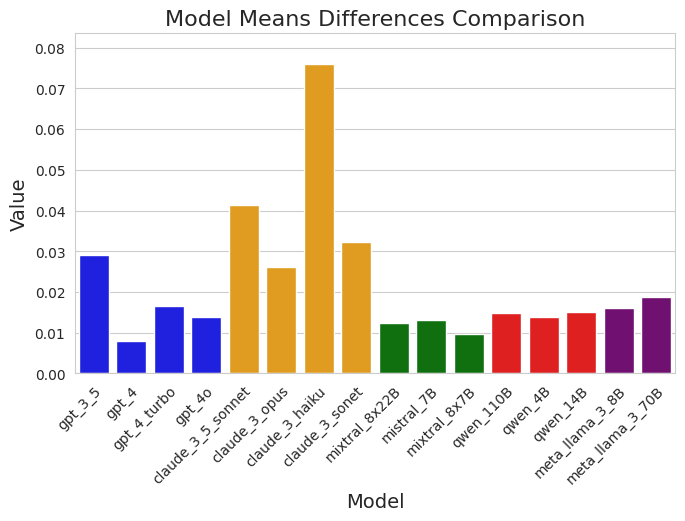

In [12]:
plot_total_means_differences(total_mean_diff)

### 6. Distributions

In [ ]:
for record in female_male_dfs:
    female_df = record['female_df']
    male_df = record['male_df']
    
    wilcoxon_pvalues = compute_wilcoxon_pvalues(female_df, male_df, text_feature_cols, record['model_name'])
    wilcoxon_pvalues_0_05 = {feature: pvalue for feature, pvalue in wilcoxon_pvalues.items() if pvalue < PVALUE}
    
    plot_features_distribution(male_df, female_df, wilcoxon_pvalues_0_05, PVALUE, record['model_name'], path_to_save=PLOTS_DIR+'/distributions', show=False)
    